# Notebook to test and illustrate superfast

In [1]:
%load_ext autoreload
%autoreload 2

### Tests on single image

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import fast

In [3]:
cap = cv2.VideoCapture('imgs/person_dog.mp4')

In [91]:
for i in range(10):
    ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
keypoints = fast.detect(np.asarray(gray, dtype="int32"), threshold=15, step=5)

In [92]:
keypoints.shape

(1148, 2)

#### FAST returns points if its neighboring pixels are different.
It should not return key points on smooth walls (because all points are similar).
It should mainly return points on edges with strong color change (clothes-bottom, color change on the dog, leaves, grass, etc.).

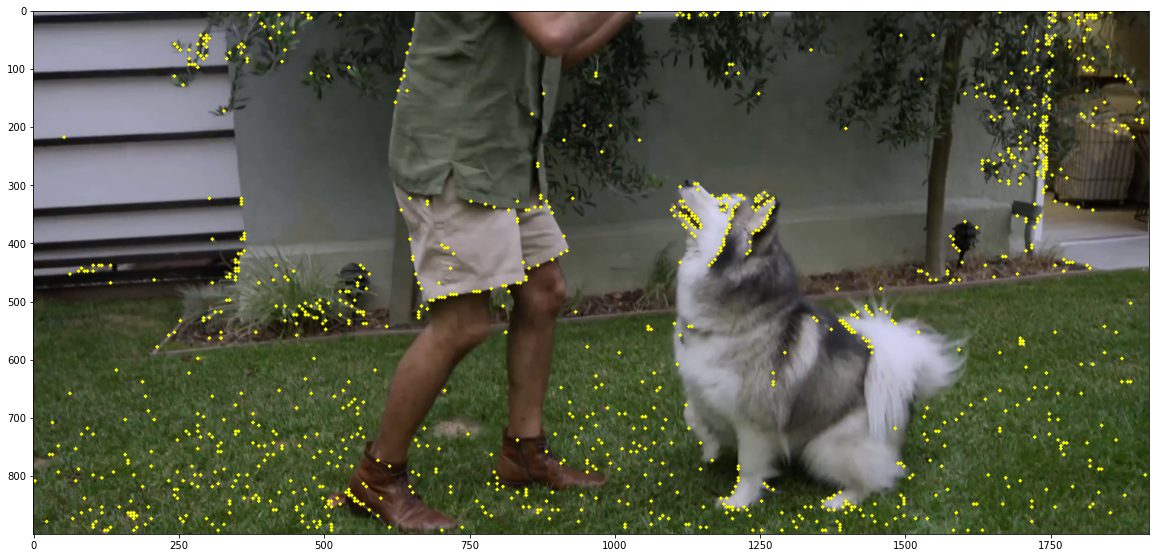

In [93]:
img_with_kp = fast.draw(frame, keypoints)
#cv2.imwrite("imgs/person_dog_kp_detector.png", img_with_kp)

fig=plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))

### Test on video

In [9]:
cap = cv2.VideoCapture('imgs/person_dog.mp4')

START_IDX = 60
END_IDX = 210
IDX = 0

ret, frame = cap.read()
result_gif = 'imgs/person_dog_kp_detector.gif'

imgs = []
skip = 3

while ret:
    if IDX % skip != 0:
        ret, frame = cap.read()
        IDX += 1
        continue
    if START_IDX <= IDX < END_IDX:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        keypoints = fast.detect(np.asarray(gray, dtype="int32"), threshold=15, step=5)
        img_with_kp = fast.draw(frame, keypoints)
        imgs.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
    elif IDX >= END_IDX:
        break
    ret, frame = cap.read()
    IDX += 1
    print(f'IDX={IDX}', end='\r')

imgs[0].save(result_gif, format='GIF',
             append_images=imgs[1:],
             save_all=True, loop=0)

cap.release()
cv2.destroyAllWindows()